In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
train_data_dir = 'category_train'
categories = os.listdir(train_data_dir)
print(categories)

['Dress', 'Jacket', 'Jeans', 'Shoes', 'Sweater', 'T-shirt']


In [3]:
num_labels = len(categories)

category_to_label = {
    colour: idx for idx, colour in enumerate(categories)
}

label_to_category = {
    idx: colour for idx, colour in enumerate(categories)
}

print(num_labels)
print(category_to_label)
print(label_to_category)


6
{'Dress': 0, 'Jacket': 1, 'Jeans': 2, 'Shoes': 3, 'Sweater': 4, 'T-shirt': 5}
{0: 'Dress', 1: 'Jacket', 2: 'Jeans', 3: 'Shoes', 4: 'Sweater', 5: 'T-shirt'}


In [4]:
def random_pick() -> tuple[np.ndarray, int]:
    category = random.choice(categories)
    img_fnames = os.listdir(f'{train_data_dir}/{category}')
    img_path = f'{train_data_dir}/{category}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = category_to_label[category]
    return img, label

image_shape=(245, 206, 3)


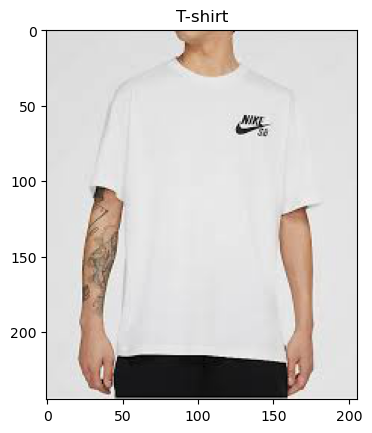

In [5]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_category[label])
plt.show()

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
# create a class to preload the images and transform for pytorch processing

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose( # chain sequence of image transformations together
            [
                transforms.Resize((500, 500)), # resize it to a square of 224x224
                transforms.ToTensor(), # converts this to a pytorch tensor; these tensors are pivotal to pytorch neural networking
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalizes the pixel value of the image
            ]
        )
        
    def load(self, img_path): # uses Python Imaging Library (PIL) to open image
        img = Image.open(img_path).convert('RGB') # open image and convert to RGB
        t_img = self.transform(img) # transform the image defined above
        return t_img

In [8]:
class ImageDataset(Dataset):

    train_data_dir = 'category_train'

    def __init__ (self, image_loader):
        categories = os.listdir(self.train_data_dir)

        self.data = []

        for category in tqdm(categories):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{category}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{category}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = category_to_label[category]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [9]:
dataset = ImageDataset(ImageLoader())

100%|██████████| 6/6 [00:04<00:00,  1.50it/s]


In [10]:
dataset[0][1].shape

torch.Size([3, 500, 500])

In [11]:
val_ratio = 0.3
test_size = 30

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest



In [12]:
len(dataset)

258

In [13]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 151, val: 77, test: 30


In [14]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = True)

In [15]:
import torch.nn as nn

In [49]:
class CategoryClassifier(nn.Module):
    def __init__(self):
        super(CategoryClassifier, self).__init__()
        
        # convolutional layer output size:
        # [(Input - Kernel Size + 2 * Padding)/Stride] + 1

        # MaxPooling Layer
        # [(Input - Kernel Size)/Stride] + 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=6, stride=4, padding=1), # [(500 - 6 + 2 * 1) / 4] + 1 = 125
            nn.MaxPool2d(kernel_size=3, stride=2), # [(125 - 3) / 2] + 1 = 62
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=4, padding=3), # [(62 - 4 + 2 * 3) / 4] + 1 = 17
            nn.MaxPool2d(kernel_size=2, stride=3), # [(17 - 2) / 3] + 1 = 6
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=1), # [(6 - 2 + 2 * 1) / 2] + 1 = 4
            nn.MaxPool2d(kernel_size=4, stride=1), # ([4 - 4) / 1] + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )


        self.fc3 = nn.Sequential(
            nn.Linear(256, num_labels)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        #print(x.size())
        x = self.conv2(x)
        #print(x.size())
        x = self.conv3(x)
        #print(x.size())
        x = self.conv4(x)
        #print(x.size())
        x = self.fc1(x)
        #print(x.size())
        x = self.fc2(x)
        #print(x.size())
        x = self.fc3(x)
        #print(x.size())
        return x

In [50]:
model = CategoryClassifier().to(device)

In [51]:
from torchsummary import summary

summary(model, (3, 500, 500))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 250, 250]           3,136
         MaxPool2d-2         [-1, 64, 125, 125]               0
       BatchNorm2d-3         [-1, 64, 125, 125]             128
              ReLU-4         [-1, 64, 125, 125]               0
         Dropout2d-5         [-1, 64, 125, 125]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
         MaxPool2d-7          [-1, 128, 32, 32]               0
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
        Dropout2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 17, 17]         131,328
        MaxPool2d-12            [-1, 256, 6, 6]               0
      BatchNorm2d-13            [-1, 256, 6, 6]             512
             ReLU-14            [-1, 25

In [52]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

In [53]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_accuracy = corrects / total
    
    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()
    
    val_loss /= len(data_loader)
    val_accuracy = corrects / total   
    
    return val_loss, val_accuracy

In [54]:
epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, validation_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=1, train_loss=2.030, val_loss=1.950, train_accuracy=0.126, val_accuracy=0.156


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=2, train_loss=1.829, val_loss=1.849, train_accuracy=0.192, val_accuracy=0.143


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=3, train_loss=1.783, val_loss=2.094, train_accuracy=0.205, val_accuracy=0.169


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=4, train_loss=1.770, val_loss=2.735, train_accuracy=0.225, val_accuracy=0.169


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=5, train_loss=1.822, val_loss=2.001, train_accuracy=0.205, val_accuracy=0.169


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=6, train_loss=1.774, val_loss=1.905, train_accuracy=0.238, val_accuracy=0.234


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch=7, train_loss=1.777, val_loss=1.797, train_accuracy=0.225, val_accuracy=0.247


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=8, train_loss=1.746, val_loss=1.723, train_accuracy=0.245, val_accuracy=0.195


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=9, train_loss=1.740, val_loss=1.726, train_accuracy=0.272, val_accuracy=0.208


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=10, train_loss=1.666, val_loss=1.879, train_accuracy=0.285, val_accuracy=0.208


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=11, train_loss=1.643, val_loss=1.763, train_accuracy=0.351, val_accuracy=0.247


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=12, train_loss=1.696, val_loss=1.618, train_accuracy=0.325, val_accuracy=0.221


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=13, train_loss=1.683, val_loss=1.602, train_accuracy=0.278, val_accuracy=0.221


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=14, train_loss=1.638, val_loss=1.643, train_accuracy=0.351, val_accuracy=0.234


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=15, train_loss=1.600, val_loss=2.894, train_accuracy=0.391, val_accuracy=0.221


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=16, train_loss=1.636, val_loss=1.848, train_accuracy=0.384, val_accuracy=0.273


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=17, train_loss=1.670, val_loss=1.614, train_accuracy=0.325, val_accuracy=0.260


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=18, train_loss=1.504, val_loss=1.833, train_accuracy=0.384, val_accuracy=0.234


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=19, train_loss=1.495, val_loss=1.740, train_accuracy=0.384, val_accuracy=0.260


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=20, train_loss=1.661, val_loss=1.743, train_accuracy=0.384, val_accuracy=0.286


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=21, train_loss=1.541, val_loss=1.633, train_accuracy=0.344, val_accuracy=0.247


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch=22, train_loss=1.599, val_loss=1.605, train_accuracy=0.344, val_accuracy=0.208


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=23, train_loss=1.528, val_loss=1.591, train_accuracy=0.424, val_accuracy=0.286


100%|██████████| 3/3 [00:04<00:00,  1.67s/it]


epoch=24, train_loss=1.559, val_loss=1.632, train_accuracy=0.358, val_accuracy=0.312


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=25, train_loss=1.405, val_loss=1.717, train_accuracy=0.417, val_accuracy=0.338


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=26, train_loss=1.397, val_loss=1.697, train_accuracy=0.444, val_accuracy=0.312


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=27, train_loss=1.411, val_loss=1.682, train_accuracy=0.470, val_accuracy=0.273


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=28, train_loss=1.256, val_loss=1.530, train_accuracy=0.536, val_accuracy=0.416


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=29, train_loss=1.317, val_loss=1.640, train_accuracy=0.477, val_accuracy=0.351


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=30, train_loss=1.330, val_loss=1.664, train_accuracy=0.503, val_accuracy=0.299


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=31, train_loss=1.076, val_loss=1.738, train_accuracy=0.589, val_accuracy=0.377


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=32, train_loss=1.204, val_loss=2.060, train_accuracy=0.596, val_accuracy=0.325


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=33, train_loss=1.062, val_loss=1.917, train_accuracy=0.576, val_accuracy=0.377


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=34, train_loss=1.071, val_loss=2.155, train_accuracy=0.609, val_accuracy=0.403


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=35, train_loss=1.167, val_loss=2.025, train_accuracy=0.596, val_accuracy=0.364


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=36, train_loss=1.285, val_loss=1.909, train_accuracy=0.589, val_accuracy=0.338


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


epoch=37, train_loss=1.059, val_loss=1.986, train_accuracy=0.603, val_accuracy=0.429


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=38, train_loss=1.117, val_loss=1.695, train_accuracy=0.689, val_accuracy=0.429


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=39, train_loss=1.155, val_loss=2.010, train_accuracy=0.603, val_accuracy=0.403


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=40, train_loss=0.838, val_loss=1.639, train_accuracy=0.656, val_accuracy=0.442


100%|██████████| 3/3 [00:04<00:00,  1.67s/it]


epoch=41, train_loss=0.910, val_loss=1.663, train_accuracy=0.715, val_accuracy=0.416


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


epoch=42, train_loss=0.866, val_loss=1.558, train_accuracy=0.695, val_accuracy=0.403


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=43, train_loss=0.859, val_loss=2.035, train_accuracy=0.715, val_accuracy=0.455


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=44, train_loss=0.756, val_loss=2.100, train_accuracy=0.728, val_accuracy=0.468


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=45, train_loss=0.846, val_loss=1.831, train_accuracy=0.702, val_accuracy=0.455


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=46, train_loss=0.771, val_loss=1.807, train_accuracy=0.702, val_accuracy=0.455


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=47, train_loss=0.729, val_loss=2.201, train_accuracy=0.748, val_accuracy=0.506


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=48, train_loss=0.858, val_loss=1.970, train_accuracy=0.715, val_accuracy=0.455


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=49, train_loss=0.718, val_loss=1.924, train_accuracy=0.788, val_accuracy=0.403


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=50, train_loss=0.768, val_loss=2.053, train_accuracy=0.788, val_accuracy=0.364


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=51, train_loss=0.922, val_loss=1.883, train_accuracy=0.728, val_accuracy=0.429


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=52, train_loss=0.614, val_loss=1.630, train_accuracy=0.762, val_accuracy=0.468


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=53, train_loss=0.869, val_loss=1.362, train_accuracy=0.768, val_accuracy=0.506


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch=54, train_loss=0.800, val_loss=1.954, train_accuracy=0.748, val_accuracy=0.468


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch=55, train_loss=0.719, val_loss=2.092, train_accuracy=0.788, val_accuracy=0.403


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=56, train_loss=0.754, val_loss=2.249, train_accuracy=0.781, val_accuracy=0.403


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=57, train_loss=0.518, val_loss=1.882, train_accuracy=0.808, val_accuracy=0.455


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=58, train_loss=0.632, val_loss=2.112, train_accuracy=0.801, val_accuracy=0.442


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=59, train_loss=0.560, val_loss=2.271, train_accuracy=0.808, val_accuracy=0.351


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=60, train_loss=0.892, val_loss=1.919, train_accuracy=0.755, val_accuracy=0.377


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=61, train_loss=0.473, val_loss=2.203, train_accuracy=0.828, val_accuracy=0.442


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=62, train_loss=0.598, val_loss=1.549, train_accuracy=0.821, val_accuracy=0.519


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=63, train_loss=0.478, val_loss=1.723, train_accuracy=0.848, val_accuracy=0.481


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=64, train_loss=0.361, val_loss=1.627, train_accuracy=0.868, val_accuracy=0.506


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=65, train_loss=0.468, val_loss=1.993, train_accuracy=0.861, val_accuracy=0.494


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=66, train_loss=0.524, val_loss=1.783, train_accuracy=0.815, val_accuracy=0.468


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=67, train_loss=0.493, val_loss=2.199, train_accuracy=0.841, val_accuracy=0.442


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=68, train_loss=0.538, val_loss=2.227, train_accuracy=0.828, val_accuracy=0.468


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=69, train_loss=0.467, val_loss=1.654, train_accuracy=0.821, val_accuracy=0.481


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=70, train_loss=0.634, val_loss=1.897, train_accuracy=0.868, val_accuracy=0.403


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=71, train_loss=0.392, val_loss=1.956, train_accuracy=0.868, val_accuracy=0.416


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=72, train_loss=0.542, val_loss=2.107, train_accuracy=0.848, val_accuracy=0.416


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=73, train_loss=0.519, val_loss=1.770, train_accuracy=0.861, val_accuracy=0.468


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=74, train_loss=0.395, val_loss=1.921, train_accuracy=0.887, val_accuracy=0.468


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=75, train_loss=0.480, val_loss=1.824, train_accuracy=0.868, val_accuracy=0.442


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=76, train_loss=0.379, val_loss=2.058, train_accuracy=0.887, val_accuracy=0.481


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=77, train_loss=0.405, val_loss=2.415, train_accuracy=0.874, val_accuracy=0.519


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=78, train_loss=0.332, val_loss=1.708, train_accuracy=0.881, val_accuracy=0.532


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=79, train_loss=0.565, val_loss=1.798, train_accuracy=0.828, val_accuracy=0.519


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=80, train_loss=0.388, val_loss=2.161, train_accuracy=0.894, val_accuracy=0.519


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


epoch=81, train_loss=0.498, val_loss=1.525, train_accuracy=0.887, val_accuracy=0.506


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=82, train_loss=0.541, val_loss=2.013, train_accuracy=0.848, val_accuracy=0.481


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


epoch=83, train_loss=0.438, val_loss=2.642, train_accuracy=0.868, val_accuracy=0.481


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=84, train_loss=0.387, val_loss=2.027, train_accuracy=0.854, val_accuracy=0.429


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=85, train_loss=0.343, val_loss=2.336, train_accuracy=0.874, val_accuracy=0.429


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=86, train_loss=0.503, val_loss=2.160, train_accuracy=0.887, val_accuracy=0.519


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=87, train_loss=0.295, val_loss=2.116, train_accuracy=0.914, val_accuracy=0.558


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=88, train_loss=0.436, val_loss=1.942, train_accuracy=0.894, val_accuracy=0.519


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=89, train_loss=0.833, val_loss=2.091, train_accuracy=0.854, val_accuracy=0.481


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=90, train_loss=0.331, val_loss=2.543, train_accuracy=0.894, val_accuracy=0.455


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=91, train_loss=0.497, val_loss=1.983, train_accuracy=0.854, val_accuracy=0.481


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=92, train_loss=0.346, val_loss=2.314, train_accuracy=0.921, val_accuracy=0.442


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


epoch=93, train_loss=0.446, val_loss=1.863, train_accuracy=0.907, val_accuracy=0.377


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=94, train_loss=0.256, val_loss=1.907, train_accuracy=0.927, val_accuracy=0.416


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=95, train_loss=0.319, val_loss=2.236, train_accuracy=0.907, val_accuracy=0.455


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch=96, train_loss=0.372, val_loss=2.353, train_accuracy=0.914, val_accuracy=0.442


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=97, train_loss=0.409, val_loss=2.282, train_accuracy=0.921, val_accuracy=0.403


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch=98, train_loss=0.211, val_loss=2.138, train_accuracy=0.934, val_accuracy=0.429


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch=99, train_loss=0.332, val_loss=2.013, train_accuracy=0.894, val_accuracy=0.403


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch=100, train_loss=0.270, val_loss=2.547, train_accuracy=0.914, val_accuracy=0.468


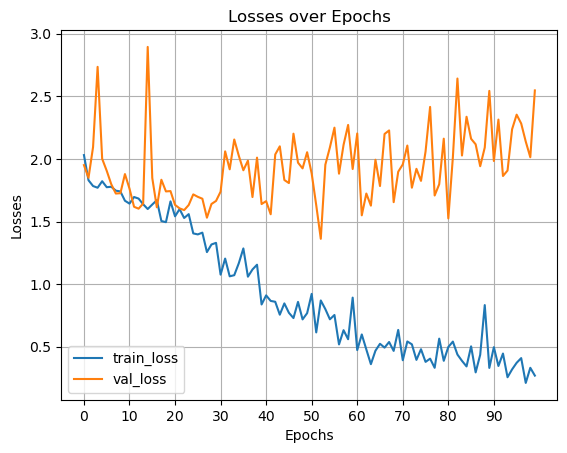

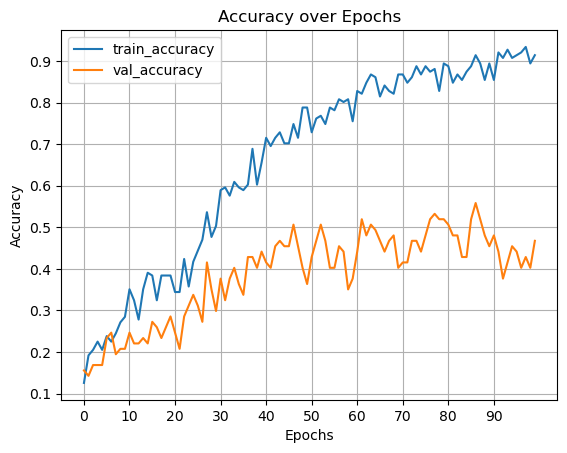

In [55]:
def plot_metrics(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(epochs), train_metric)
    plt.plot(range(epochs), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage for losses
plot_metrics(epochs, train_losses, val_losses, 'loss', 'Losses', 'Losses over Epochs')

# Example usage for accuracies
plot_metrics(epochs, train_accuracies, val_accuracies, 'accuracy', 'Accuracy', 'Accuracy over Epochs')

In [56]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(10))
sample_loader = DataLoader(sample_data, batch_size=30)

In [57]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    axes = np.reshape(axes, (math.ceil(len(img_paths) / 5), 5))  # Reshape axes array
    
    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])
        
        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'Actual Category: {label_to_category[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f"Predicted {label_to_category[best_idx0]}: {outputs[i, best_idx0]*100:.2f}%\n"
        title += f"Predicted {label_to_category[best_idx1]}: {outputs[i, best_idx1]*100:.2f}%\n"
        axes[i // 5, i % 5].set_title(title)

    plt.show()

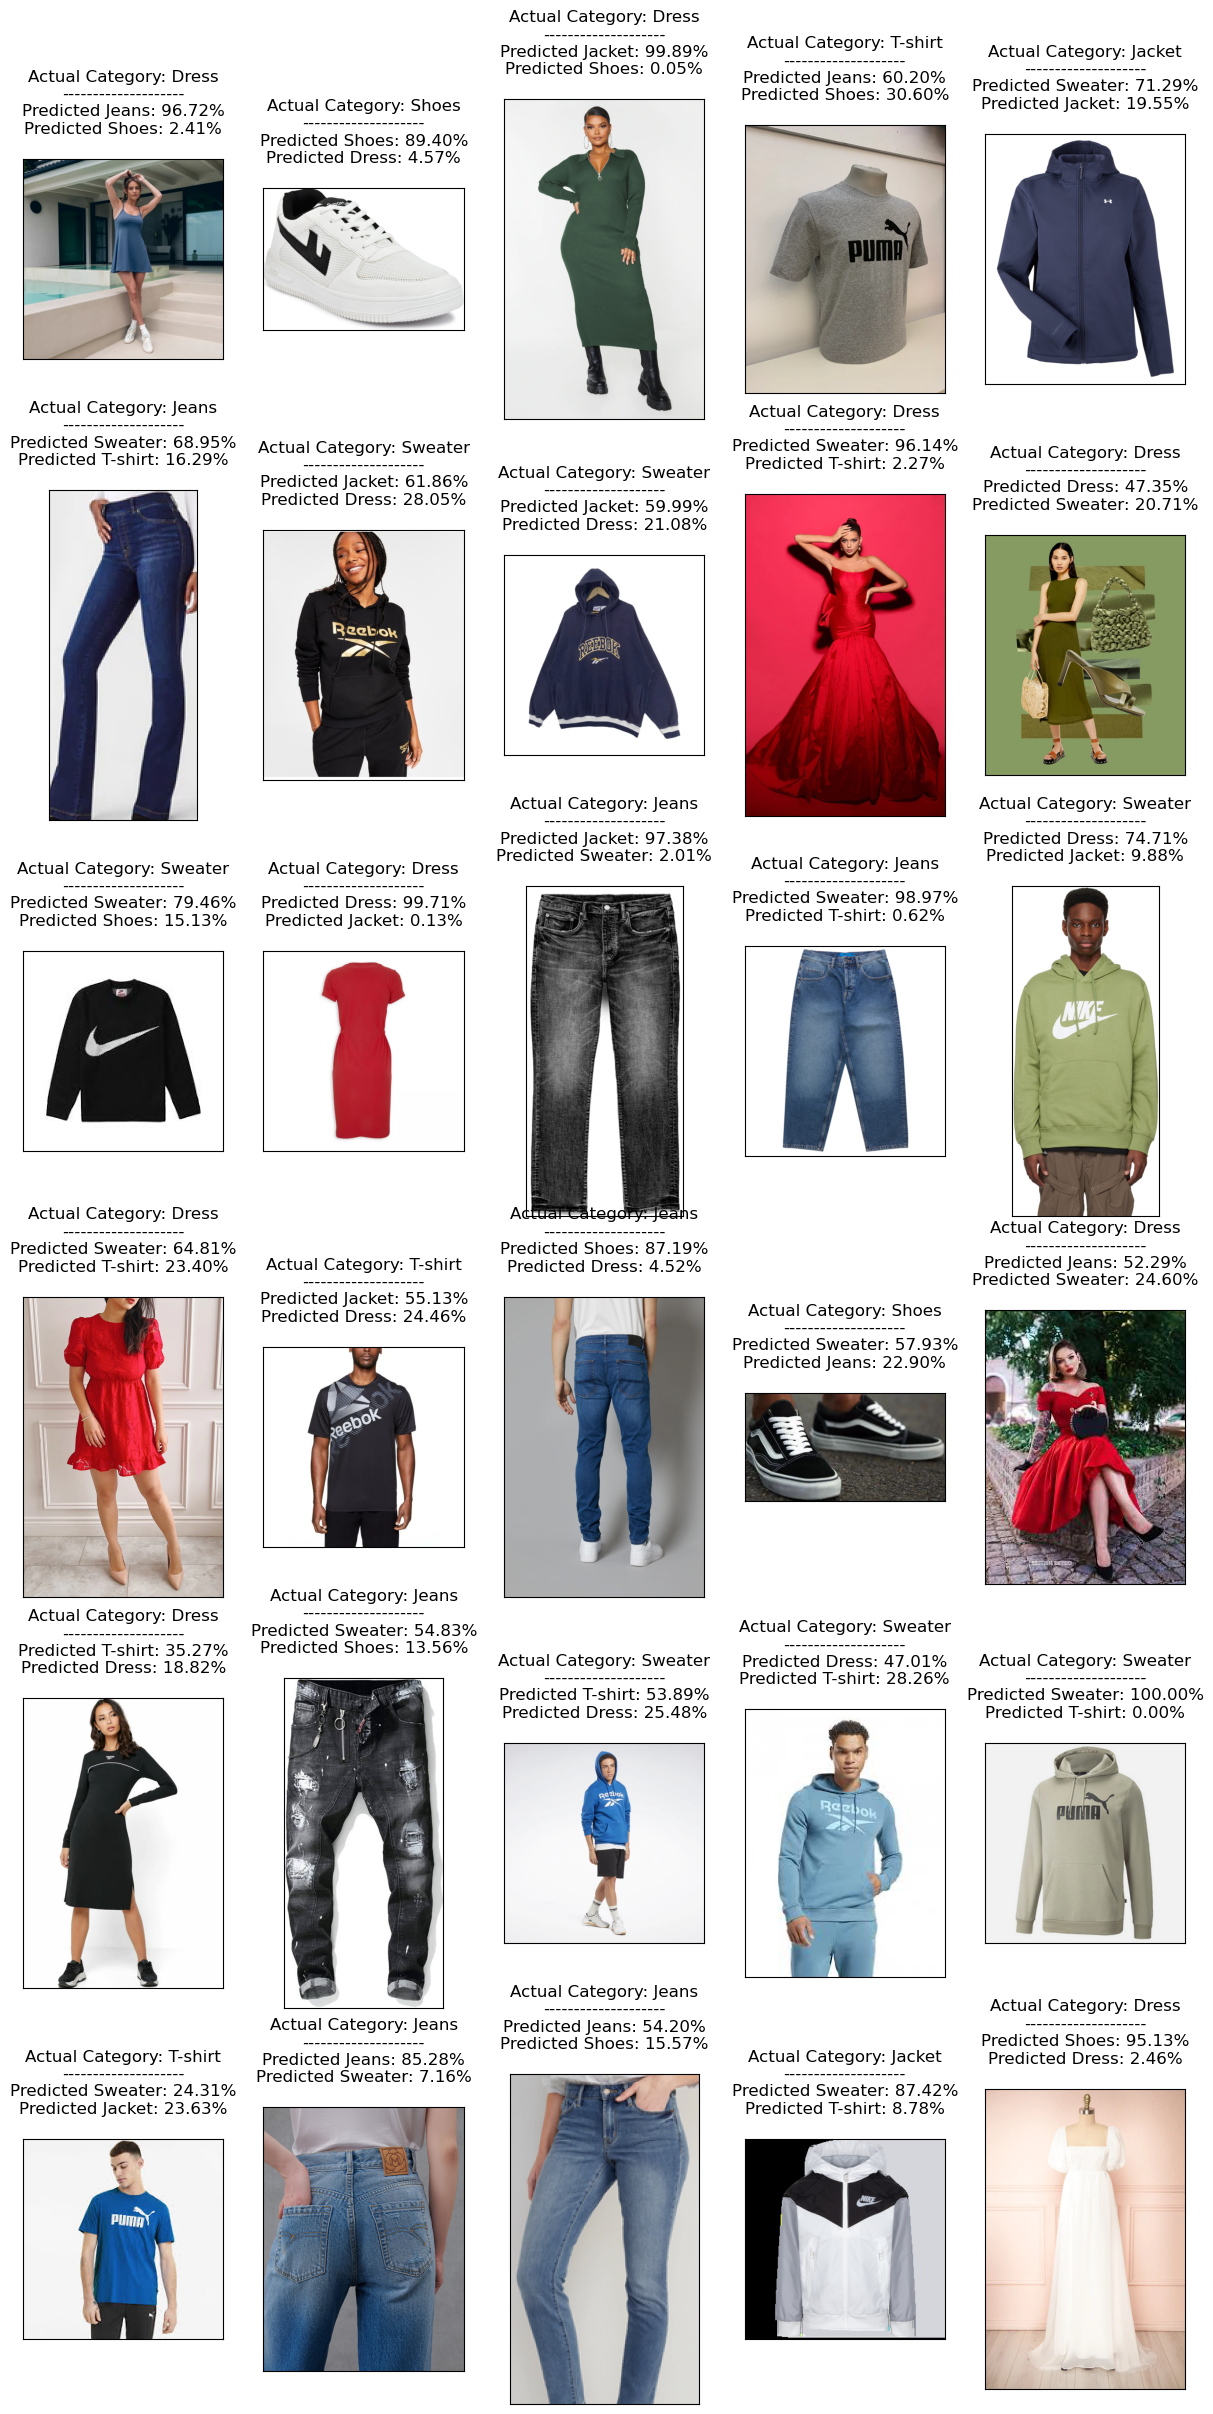

In [58]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)